In [ ]:
!pip install kaggle # Access Kaggle API

In [ ]:
!kaggle datasets download -d andrewmvd/medical-mnist # Download dataset from Kaggle

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/medical-mnist
License(s): other
 90% 76.0M/84.8M [00:01<00:00, 74.7MB/s]
100% 84.8M/84.8M [00:01<00:00, 63.0MB/s]


In [ ]:
!unzip /content/medical-mnist.zip -d /content/medical-mnist # Unzip the dataset

# **Building a Convolutional Neural Network to Classifiy Medical Images**
Using a dataset from Kaggle, we will build a model, train it, and optimize.

***Any unecessary comments -such as definitions and explanations as to how things work-  are for me, as I am learning and trying to make sure I understand every component I implement***

# Importing the Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras


# Importing the Dataset

The dataset consists of 58954 medical images belonging to 6 classes. There are 6 subfolders to load data from.

- The image_dataset_from_directory() function from TensorFlow's Keras API automatically loads and labels images from a directory structure.


The dataset will be split into 3 subsets.
- Training set
- Cross-validation set
- Testing set

We will train a model on the training set, select a model based on the cross-validation set and test the selected model based on the testing set.


In [ ]:
dataset_directory = '/content/medical-mnist'

#define some parameter
img_height = 64
img_width = 64

# Load the training dataset with validation_split=0.4, so that 40% of the data will be reserved for validation set
X_train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_directory,
    image_size=(img_height, img_width),
    labels='inferred',  # Label images from folder names
    shuffle=True,  # Shuffle data for randomness
    validation_split=0.4,  # 40% will be saved for validation + test
    subset="training",     # First load the training data subset (60%)
    seed=123              # Ensure reproducibility
)

# Load the validation dataset (this will be 40% of the original dataset - 20% for validation set and 20% for testing set)
validation_and_test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_directory,
    image_size=(img_height, img_width),
    labels='inferred',
    shuffle=True,  # Shuffle for randomness
    validation_split=0.4,  # Split off 40% for validation and testing
    subset="validation",   # This is the validation set
    seed=123              # Ensure reproducibility
)

# Split the validation_and_test_dataset into validation and testing
# 20% for validation and 20% for testing

# Create validation dataset (20% of total)
validation_size = int(len(validation_and_test_dataset)//2)  # Split the 40% in half
test_size = len(validation_and_test_dataset) - validation_size  # The rest goes to testing

# Get the first half for validation
X_cv = validation_and_test_dataset.take(validation_size)

# Get the second half for testing
X_test = validation_and_test_dataset.skip(validation_size)


# Training dataset: 60% of the data
# Validation dataset: 20% of the data
# Test dataset: 20% of the data

Found 58954 files belonging to 6 classes.
Using 35373 files for training.
Found 58954 files belonging to 6 classes.
Using 23581 files for validation.


# Visualize Data
Print the first 6 images to visualize the data we are working with.
- take() method extracts a given number of elements from the dataset
- by default, we work in batches of 32, but we will only show the first 6 images

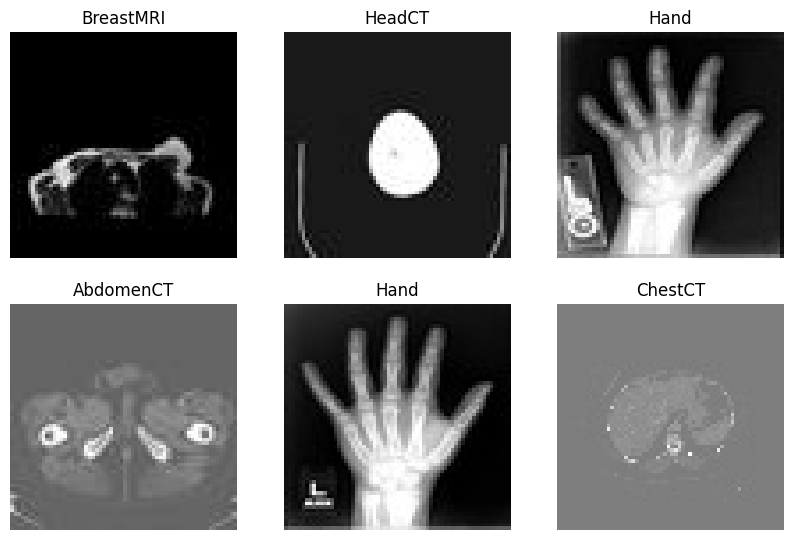

In [ ]:
import matplotlib.pyplot as plt

# Visualize the first 6 images from the training dataset
plt.figure(figsize=(10, 10))
for images, labels in X_train.take(1):  # Take only one batch of images - each batch is 32 images of shape 64x64x3
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(X_train.class_names[labels[i]])
    plt.axis("off")

# Build Initial Model
Start with a popular model and work from there.

No need to invent the wheel.

Models considered were LeNet-5, AlexNet, and VGG-16, but opted for AlexNet as a balance in factors such as performance and resource usage.


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [ ]:
num_classes = len(X_train.class_names)

model = Sequential([
    tf.keras.layers.Rescaling(1./255),  # Normalize pixel values to [0, 1]
    # Conv1
    tf.keras.layers.Conv2D(32, (5, 5), strides=1, activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    # Conv2
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    # Conv3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    # Conv4
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    # Conv5
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    # Flatten
    tf.keras.layers.Flatten(),
    # Fully Connected Layers
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Compile the Model

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

# The metrics argument is to view training and validation accuracy for each training epoch

model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


# Train the model

In [ ]:
loss_plot = model.fit(X_train, epochs=10, validation_data=(X_cv))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1106/1106 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.8897 - loss: 0.2923 - val_accuracy: 0.9911 - val_loss: 0.0634
Epoch 2/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9902 - loss: 0.0435 - val_accuracy: 0.9945 - val_loss: 0.0452
Epoch 3/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9955 - loss: 0.0216 - val_accuracy: 0.9986 - val_loss: 0.0142
Epoch 4/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.9936 - loss: 0.0226 - val_accuracy: 0.9975 - val_loss: 0.0140
Epoch 5/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9956 - loss: 0.0241 - val_accuracy: 0.9982 - val_loss: 0.0098
Epoch 6/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9972 - loss: 0.0144 - val_accuracy: 0.9981 - val_loss: 0.0171
Epoch 7/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9959 - loss: 0.0189 - val_accuracy: 0.9986 - val_loss: 0.0042
Epoch 8/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9977 - loss: 0.0080 - 

# Visualize Loss to Asses Generalization

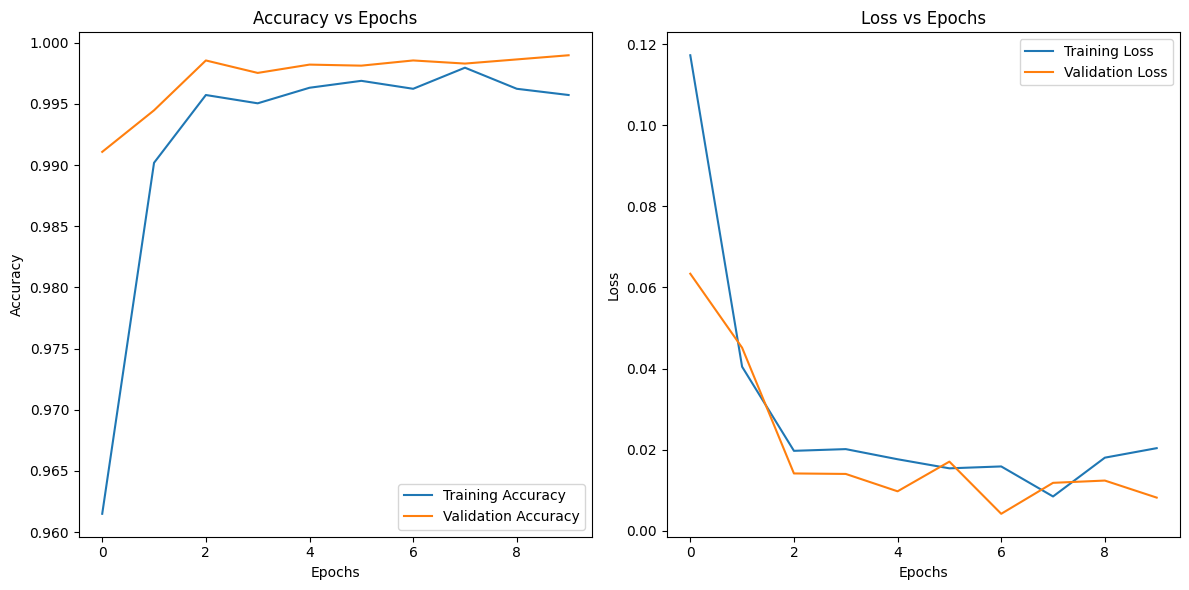

In [ ]:
# Plotting Accuracy
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(loss_plot.history['accuracy'], label='Training Accuracy')
plt.plot(loss_plot.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(loss_plot.history['loss'], label='Training Loss')
plt.plot(loss_plot.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation

In [ ]:
test_loss, test_acc = model.evaluate(X_test)

369/369 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9988 - loss: 0.0042


# Predict the first three images of test set

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Iterator for the test dataset
test_iter = iter(X_test)

# First batch of images and labels
batch_images, batch_labels = next(test_iter)

# First 3 images from the batch
first_three_images = batch_images[:3]  # Get the first 3 images
first_three_labels = batch_labels[:3]  # Get the corresponding true labels

# Make predictions for these three images
predictions = model.predict(first_three_images)
predicted_labels = np.argmax(predictions, axis=1)

# Print the true labels and predicted labels
print("True labels:", first_three_labels)  # No need for np.argmax if labels are integers
print("Predicted labels:", predicted_labels)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
True labels: tf.Tensor([3 5 0], shape=(3,), dtype=int32)
Predicted labels: [3 5 0]
